In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

In [2]:
import sys
if "../src/" not in sys.path:
    sys.path.insert(0,"../src/")
from pbcpy.base import DirectCell, ReciprocalCell, Coord
from pbcpy.grid import DirectGrid, ReciprocalGrid
from pbcpy.field import DirectField, ReciprocalField
from pbcpy.functionals import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
#

In [3]:
from pbcpy.local_functionals_utils import ThomasFermiEnergy, ThomasFermiPotential
from pbcpy.local_functionals_utils import vonWeizsackerEnergy, vonWeizsackerPotential

In [4]:
from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF

In [5]:
from pbcpy.semilocal_xc import PBE, LDA, XC

In [6]:
mol = PP(filepp='Al_fde_rho.pp').read()
rho_of_r = mol.field

# $E_{eN}$ and $v_{eN}$ but not yet $E_{NN}$

In [7]:
#Need to fix the path to PP files and attach it to the ions class
def NuclearElectron(ions,density):
    natoms=np.shape(ions)[0]
    NuclearElectron = ions[0].local_PP(grid=density.grid,rho=density,outfile='./Al_lda.oe01.recpot')
    for i in range(1,natoms,1):
        eN_tmp = ions[i].local_PP(grid=density.grid,rho=density,outfile='./Al_lda.oe01.recpot')
        NuclearElectron = NuclearElectron.sum(eN_tmp)
    NuclearElectron.name = 'Local Pseudopotential'
    return NuclearElectron

In [8]:
NuclearElectron = NuclearElectron(mol.ions,rho_of_r)

ion charge =  3.0
Recpot pseudopotential ./Al_lda.oe01.recpot loaded
ion charge =  3.0
Recpot pseudopotential ./Al_lda.oe01.recpot loaded


In [9]:
type(NuclearElectron.energydensity)

pbcpy.field.DirectField

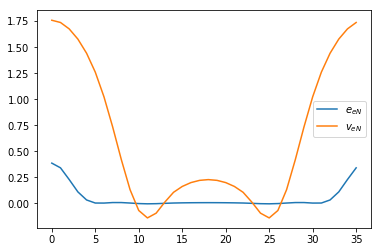

In [10]:
plt.plot(NuclearElectron.energydensity[:,0,0,0],label=r'$e_{eN}$')
plt.plot(NuclearElectron.potential[:,0,0,0],label=r'$v_{eN}$')
plt.legend()
plt.show()

In [11]:
NuclearElectron.name

'Local Pseudopotential'

# $E_H$ and $v_{H}$

In [12]:
def HartreeFunctional(density):
    gg=density.grid.get_reciprocal().gg
    rho_of_g = density.fft()
    v_h = ReciprocalField(density.grid.get_reciprocal(),griddata_3d=np.zeros(np.shape(rho_of_g)))
    mask = gg != 0
    v_h[mask] = rho_of_g[mask]*gg[mask]**(-1)*4*np.pi
    v_h_of_r = v_h.ifft(force_real=True)
    e_h = v_h_of_r*density/2.0
    return Functional(name='Hartree', potential=v_h_of_r, energydensity=e_h)

In [13]:
Hartree = HartreeFunctional(rho_of_r)

/Users/michele/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [14]:
np.shape(Hartree.energydensity)

(36, 36, 72, 1)

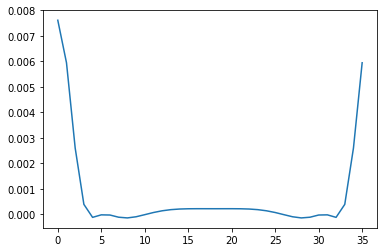

In [15]:
plt.plot(Hartree.energydensity[:,0,0,0])
plt.show()

# $E_{xc}$ and $v_{xc}$

In [16]:
ExchangeCorrelation_LDA = LDA(rho_of_r,polarization='unpolarized')

In [17]:
ExchangeCorrelation_PBE = PBE(rho_of_r,polarization='unpolarized')

# Check against PROFESS

In [18]:
ion_profess = PP("./pot_pp/pot_ion.pp").read()
xc_profess = PP("./pot_pp/pot_XC.pp").read()
xc_pbe_profess = PP("./pot_pp/pot_XC_PBE.pp").read()
hart_profess = PP("./pot_pp/pot_H.pp").read()

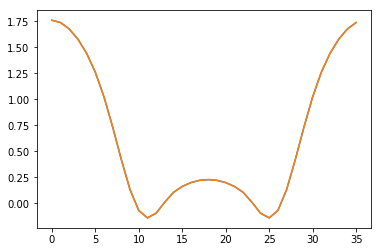

In [19]:
plt.plot(ion_profess.field[:,0,0,0])
plt.plot(NuclearElectron.potential[:,0,0,0])
plt.show()

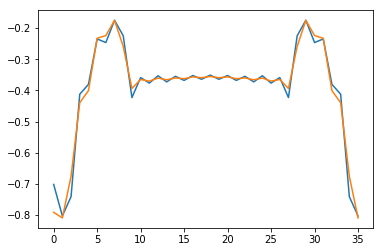

In [21]:
#plt.plot(xc_profess.field[:,0,0,0])
plt.plot(xc_pbe_profess.field[:,0,0,0])
#plt.plot(ExchangeCorrelation_LDA.potential[:,0,0,0])
plt.plot(ExchangeCorrelation_PBE.potential[:,0,0,0])
plt.show()

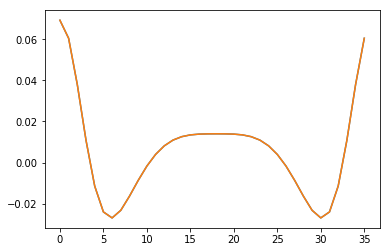

In [22]:
plt.plot(hart_profess.field[:,0,0,0])
plt.plot(Hartree.potential[:,0,0,0])
plt.show()

In [31]:
rho_of_r.gradient(flag='regular')

# Total $E - E_{NN}$

In [20]:
Energy = Hartree.sum(ExchangeCorrelation.sum(NuclearElectron))

In [21]:
Energy.energydensity.integral()

-0.25850431149272657

In [22]:
Kinetic = XC(rho_of_r,'gga_k_tfvw','gga_k_tfvw','unpolarized')

In [23]:
Kinetic.energydensity = Kinetic.energydensity/2.0

In [24]:
Kinetic.potential = Kinetic.potential/2.0

In [25]:
Kinetic.energydensity.integral()

3.0353893424681537

In [26]:
27.211385*(-5.3174351741408525+3.0353893424681537)

-62.097627713291004

In [27]:
def norm(a):
    if np.shape(np.shape(a))[0] != 2:
        raise AttributeError("a must be a matrix (rank-2 vector)")
    return np.sqrt(np.einsum('ij->j',a**2))

In [28]:
norm = norm(rho_of_r.grid.lattice)

In [29]:
eta = 7/np.min(norm)

In [30]:
N = np.zeros(3)

In [31]:
1.0e-8 =  norm * eta * N

SyntaxError: can't assign to literal (<ipython-input-31-3d8b99b6650c>, line 1)

In [24]:
import pylibxc

In [30]:
pylibxc.functional.util.xc_available_functional_names()

['lda_x',
 'lda_c_wigner',
 'lda_c_rpa',
 'lda_c_hl',
 'lda_c_gl',
 'lda_c_xalpha',
 'lda_c_vwn',
 'lda_c_vwn_rpa',
 'lda_c_pz',
 'lda_c_pz_mod',
 'lda_c_ob_pz',
 'lda_c_pw',
 'lda_c_pw_mod',
 'lda_c_ob_pw',
 'lda_c_2d_amgb',
 'lda_c_2d_prm',
 'lda_c_vbh',
 'lda_c_1d_csc',
 'lda_x_2d',
 'lda_xc_teter93',
 'lda_x_1d',
 'lda_c_ml1',
 'lda_c_ml2',
 'lda_c_gombas',
 'lda_c_pw_rpa',
 'lda_c_1d_loos',
 'lda_c_rc04',
 'lda_c_vwn_1',
 'lda_c_vwn_2',
 'lda_c_vwn_3',
 'lda_c_vwn_4',
 'lda_xc_zlp',
 'lda_k_tf',
 'lda_k_lp',
 'lda_xc_ksdt',
 'lda_c_chachiyo',
 'lda_c_lp96',
 'lda_x_rel',
 'lda_xc_1d_ehwlrg_1',
 'lda_xc_1d_ehwlrg_2',
 'lda_xc_1d_ehwlrg_3',
 'lda_x_erf',
 'lda_xc_lp_a',
 'lda_xc_lp_b',
 'lda_x_rae',
 'lda_k_zlp',
 'lda_c_mcweeny',
 'lda_c_br78',
 'lda_c_pk09',
 'lda_c_ow_lyp',
 'lda_c_ow',
 'lda_xc_gdsmfb',
 'lda_c_gk72',
 'lda_c_karasiev',
 'lda_k_lp96',
 'gga_x_gam',
 'gga_c_gam',
 'gga_x_hcth_a',
 'gga_x_ev93',
 'gga_x_bcgp',
 'gga_c_bcgp',
 'gga_x_lambda_oc2_n',
 'gga_x_b86_r',
